##0. Dowloading Datasets (โหลด ชุดข้อมูล)


Dataset link download https://tuipied-my.sharepoint.com/:f:/g/personal/tanatorn_tu_ac_th/Egir27w3VCFOio3qooQ5wZsB5EPyb8JxIsspIOATjrL-yw?e=JD4M4B


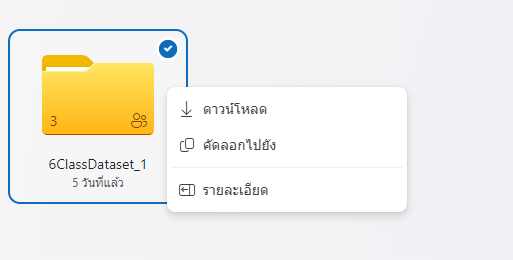

เมื่อโหลดไฟล์แล้ว ต้องแตกไฟล์แล้วให้เก็บข้อมูลไว้ใน Google Drive
โดยที่ Path ของไฟล์สามารถเก็บได้ตามใจชอบ
เช่นเก็บไว้ที่ /content/gdrive/MyDrive/dataset ดังรูป

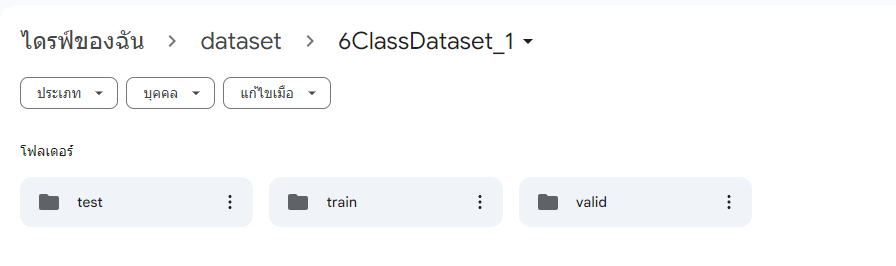

#1. Import Library and Dataset


In [1]:
!pip install tensorflow # Installs TensorFlow library
!pip install keras # Installs keras library

In [2]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import efficientnet_v2 , NASNetLarge
import tensorflow_hub as hub
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from datetime import datetime

%matplotlib inline

In [3]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


#2.  data preparation (การเตรียม ชุดข้อมูล)

**การเตรียมข้อมูล**

เป็นการจัดการชุดข้อมูลที่ได้รับมาให้เหมาะสมหรือสามารถนำมาใช้งานได้ในการ Train

อ้างอิง: https://www.nerd-data.com/data_preparation/

In [4]:
train_path = "/content/gdrive/MyDrive/dataset/(DHR)SkinDataset2/train" # @param{type:"string"}
test_path = "/content/gdrive/MyDrive/dataset/(DHR)SkinDataset2/test" # @param{type:"string"}
valid_path = "/content/gdrive/MyDrive/dataset/(DHR)SkinDataset2/valid" # @param{type:"string"}

In [5]:
# @title 2.1 Set up Custom parameter Datagen { display-mode: "form" }
ROTATION_RANGE = 0 # @param {type:"number"}
HORIZONTAL_FLIP = False # @param{type:"boolean"}
VERTICAL_FLIP = False # @param{type:"boolean"}
ZOOM_RANGE = 0 # @param {type:"number"}
WIDTH_SHIFT_RANGE = 0 # @param {type:"number"}
HEIGHT_SHIFT_RANGE = 0 # @param {type:"number"}
LOW_BRIGHTNESS = 1 # @param {type: "number"}
HIGH_BRIGHTNESS = 1 # @param {type:"number"}
# ช่วงของความสว่างของภาพ <1 มืดลง >1 สว่างขึ้น
BRIGHTNESS_RANGE = [LOW_BRIGHTNESS, HIGH_BRIGHTNESS]
SHEAR_RANGE = 0 # @param {type: "number"}
FILL_MODE = "nearest" # @param ["constant", "nearest", "reflect"]
# constant เติมสีดำ, nearest เติมสีข้างเคียง, reflect เติมสีจากภาพที่มีการกลับด้าน

BATCH_SIZE = 32 # @param{type:"integer"}
IMAGE_SIZE = 224 # @param{type:"integer"}

**โดย จะมีตัวอย่างของแต่ละการทำของ ImageDataGenerator ดังนี้**
1. Random Rotation ( สุ่ม หมุนภาพ )
parameter คือ ROTATION_RANGE เป็นการกำหนดช่วงการหมุนภาพในหน่วยองศา เมื่อกำหนดค่าเริ่มต้นและสิ้นสุดของช่วงการหมุน โมเดลจะสุ่มหมุนภาพในช่วงนั้นเพื่อให้โมเดลเรียนรู้ได้ดีกว่าในสภาวะที่ภาพไม่ได้ถูกหมุน โดยค่า parameter จะเป็นหน่วยองศา 0-359

2. Random Shifts คือการเคลื่อนย้าย (shift) ภาพไปในทิศทางต่างๆ อย่างสุ่มเพื่อเพิ่มความหลากหลายในชุดข้อมูลที่ใช้ในการฝึกสอนโมเดลเชิงลึก (Deep Learning) ซึ่งเป็นหนึ่งในเทคนิคในการเตรียมข้อมูลภาพที่มีประสิทธิภาพเพื่อป้องกันการเรียนรู้จากลักษณะเฉพาะของภาพในชุดข้อมูล


3. Random Flips คือการทำการพลิกภาพในแนวนอน (horizontal flip) หรือในแนวตั้ง (vertical flip) อย่างสุ่มขณะเตรียมข้อมูลภาพสำหรับการฝึกสอนโมเดลเชิงลึก (Deep Learning) โดยมักจะใช้กับชุดข้อมูลภาพเพื่อเพิ่มความหลากหลายในการเรียนรู้ของโมเดลซึ่งช่วยลดโอกาสของการเกิดการเรียนรู้จากลักษณะของภาพที่มีเพียงแค่มุมมองหรือทิศทางการถ่ายทอดซึ่งเป็นการเพิ่มความคล้ายคลึงในการเรียนรู้ของโมเดลให้มีความคุ้นเคยกับสภาพการเอาไว้ของข้อมูลเพิ่มขึ้น

  4.
Random Brightness คือการเพิ่มหรือลดความสว่างของภาพอย่างสุ่มเพื่อเตรียมข้อมูลสำหรับการฝึกสอนโมเดลเชิงลึก (Deep Learning) โดยการปรับความสว่างนี้สามารถทำให้โมเดลมีความสามารถในการรับมือกับความแตกต่างของการสว่างแสงในภาพที่แตกต่างกันได้ เช่น การถ่ายภาพในสภาพแสงแดดแรงและสภาพแสงมัวหมอง เป็นต้น


5. Random Zoom คือการซูมภาพเข้าหรือซูมออกอย่างสุ่มเพื่อเตรียมข้อมูลสำหรับการฝึกสอนโมเดลเชิงลึก (Deep Learning) โดยการปรับการซูมนี้สามารถช่วยเพิ่มความหลากหลายในชุดข้อมูลและช่วยให้โมเดลมีความสามารถในการรับมือกับการเปลี่ยนแปลงขนาดของวัตถุในภาพได้

อ้างอิง: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/#:~:text=Keras%20ImageDataGenerator%20class%20provides%20a,on%20its%20official%20documentation%20page.

In [6]:
# @title 2.2 Run ImageDataGenerator

train_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                    height_shift_range = HEIGHT_SHIFT_RANGE,
                                    rotation_range =  ROTATION_RANGE ,
                                    horizontal_flip =  HORIZONTAL_FLIP ,
                                    vertical_flip = VERTICAL_FLIP ,
                                    zoom_range = ZOOM_RANGE ,
                                    brightness_range = BRIGHTNESS_RANGE ,
                                    shear_range = SHEAR_RANGE ,
                                    fill_mode = FILL_MODE
                                    )
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')


test_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                   height_shift_range = HEIGHT_SHIFT_RANGE,
                                   rotation_range =  ROTATION_RANGE ,
                                   horizontal_flip =  HORIZONTAL_FLIP ,
                                   vertical_flip = VERTICAL_FLIP ,
                                   zoom_range = ZOOM_RANGE ,
                                   brightness_range = BRIGHTNESS_RANGE ,
                                   shear_range = SHEAR_RANGE ,
                                   fill_mode = FILL_MODE
                                   )
test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')


valid_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                    height_shift_range = HEIGHT_SHIFT_RANGE,
                                    rotation_range =  ROTATION_RANGE ,
                                    horizontal_flip =  HORIZONTAL_FLIP ,
                                    vertical_flip = VERTICAL_FLIP ,
                                    zoom_range = ZOOM_RANGE ,
                                    brightness_range = BRIGHTNESS_RANGE ,
                                    shear_range = SHEAR_RANGE ,
                                    fill_mode = FILL_MODE
                                    )
valid_generator = valid_datagen.flow_from_directory(
        directory=valid_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')



Found 909 images belonging to 4 classes.
Found 113 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


In [7]:
class_names = train_generator.class_indices
class_names


{'Basal cell carcinoma': 0,
 'Melanoma': 1,
 'Normal skin': 2,
 'Squamous cell carcinoma': 3}

In [8]:
CLASS_SIZE = len(class_names)


#3. Create Model
ในการสร้างปัญญาประดิษฐ์ ในปัจจุบันมีการเขียนหรือสร้าง Model ต้นแบบที่มีก่อนหน้าเพื่อเป็นแนวทางในการสร้าง Training datasets ของเราโดยใน workshop นี้ได้นำ Model ที่สำเร็จรูปมา 4 โมเดลคือ


1.   MobileNetV3Small
2.   RestNet-50
3.   EfficientNetV2L
4.   NASNetLarge



In [9]:
import random
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#set seed

In [10]:
# @title เลือก Model ที่นำมาใช้ Train
model_name = "EfficientNetV2L" # @param ["MobileNetV3Small", "RestNet-50",  "EfficientNetV2L", "NASNetLarge"]

In [11]:
if model_name =="MobileNetV3Small" :
  base_model = keras.applications.MobileNetV3Small(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),include_top=False, weights='imagenet') # Load the MobileNetV3Small model
  base_model.trainable = True # Enable to train Pre-Trained Model
if model_name == "RestNet-50":
  base_model = ResNet50(
    input_shape = [IMAGE_SIZE , IMAGE_SIZE ] + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
  )
  base_model.trainable = True # Enable to train Pre-Trained Model
if model_name == "EfficientNetV2L":
  base_model = efficientnet_v2.EfficientNetV2B0(include_top=False,
                                                input_shape= [IMAGE_SIZE , IMAGE_SIZE ] + [3],
                                                weights="imagenet")

if model_name == "NASNetLarge":
  base_model = NASNetLarge(

    include_top=False,
    input_shape = [IMAGE_SIZE , IMAGE_SIZE ] + [3],
    weights="imagenet",
  )


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # Define input layer


In [12]:

x = inputs # Apply Augmentation to the input images. this use for decrease overfit
x = base_model(x, training=False) # Pass Augmentation Data to base_model
x = layers.GlobalAveragePooling2D(name="GloPool")(x) # Create Global Average Pooling and input x to get output tensor that value = Dense's filter. this use for decrease feature map
outputs = tf.keras.layers.Dense(CLASS_SIZE, activation="softmax", name="output_layer")(x) # output layer that (output unit = CLASS_SIZE as image class, activation function is softmax  )
model_0 = tf.keras.Model(inputs, outputs) # Create Model name model_0 that have input layer, base mosel, output layer
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"]) #Compile model_0 with categorical_crossentropy, adam's learning rate = 0.0001, metric by accuracy


In [13]:
model_0.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 GloPool (GlobalAveragePool  (None, 1280)              0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 5924436 (22.60 MB)
Trainable params: 5863828 (22.37 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [14]:
custom_early_stopping = EarlyStopping( # EarlyStopping is keras's callback function that stop training model before overfitting
    monitor='val_loss', # monitor at validation loss
    patience=10,
    min_delta=0.000000001, # if validation loss is not decrease at least 0.001 in 10 time
    mode='min' # need validtion loss to decrease
)

#3.Train Model

In [15]:
start = datetime.now()

history = model_0.fit(train_generator, # Use from train generator
           epochs=30, # training round
           workers=0,
           steps_per_epoch=len(train_generator), # Use from batch size that can update each epoch for training
           validation_data=valid_generator, # Use from test generator
           validation_steps=len(valid_generator),
           callbacks=[custom_early_stopping]) # Stop training when overfitting

print ('Execution Time: ',datetime.now()-start)

Epoch 1/30
29/29 [==============================] - 109s 2s/step - loss: 0.7585 - accuracy: 0.6865 - val_loss: 0.3955 - val_accuracy: 0.8482
Epoch 2/30
29/29 [==============================] - 7s 237ms/step - loss: 0.4315 - accuracy: 0.8163 - val_loss: 0.4429 - val_accuracy: 0.8393
Epoch 3/30
29/29 [==============================] - 6s 211ms/step - loss: 0.3210 - accuracy: 0.8713 - val_loss: 0.2938 - val_accuracy: 0.8661
Epoch 4/30
29/29 [==============================] - 10s 330ms/step - loss: 0.2291 - accuracy: 0.9153 - val_loss: 0.3136 - val_accuracy: 0.8750
Epoch 5/30
29/29 [==============================] - 7s 238ms/step - loss: 0.1480 - accuracy: 0.9450 - val_loss: 0.2964 - val_accuracy: 0.8839
Epoch 6/30
29/29 [==============================] - 6s 213ms/step - loss: 0.0921 - accuracy: 0.9648 - val_loss: 0.4456 - val_accuracy: 0.8571
Epoch 7/30
29/29 [==============================] - 6s 214ms/step - loss: 0.0913 - accuracy: 0.9659 - val_loss: 0.6680 - val_accuracy: 0.8482
Epoch 

In [16]:
#@title 3.2. Evaluate the model on the test set
test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

<ipython-input-16-74d96c32e9dc>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 0.5281088948249817
Test accuracy: 0.9380530714988708


#4.Evaluate Model (สรุปผล Model)






เป็นการ ประเมิณผลว่า Model ที่ Train มานั้นทำงานได้น่าพึงพอใจหรือไม่โดยใน Task classification วิธีการวัดผลที่ใช้กันคือการทำ Confusion Matrix ซึ่งประกอบด้วย 4 อย่างดังนี้


1.  True Positive (TP) คือ โมเดลจำแนกได้อย่างถูกต้องตรงกับค่าจริงที่คาดหวัง
2.  True Negative (TN) คือโมเดลจำแนกได้อย่างถูกต้องตรงกับค่าจริงที่ไม่ได้คาดหวัง
3.  False Positive (FP) คือ โมเดลจำแนกผิดพลาดไม่ตรงกับค่าจริงแต่ตรงกับค่าที่คาดหวัง
4.  False Negative (FN) คือ โมเดลจำแนกผิดพลาดไม่ตรงกับค่าจริง และตรงกับค่าที่ไม่คาดหวัง


In [17]:
# Evaluate the model on the test set
start = datetime.now()
test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test Time:',datetime.now()-start)


<ipython-input-17-0897c54d69da>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 0.5281088948249817
Test accuracy: 0.9380530714988708
Test Time: 0:00:00.856641


4/4 [==============================] - 2s 132ms/step


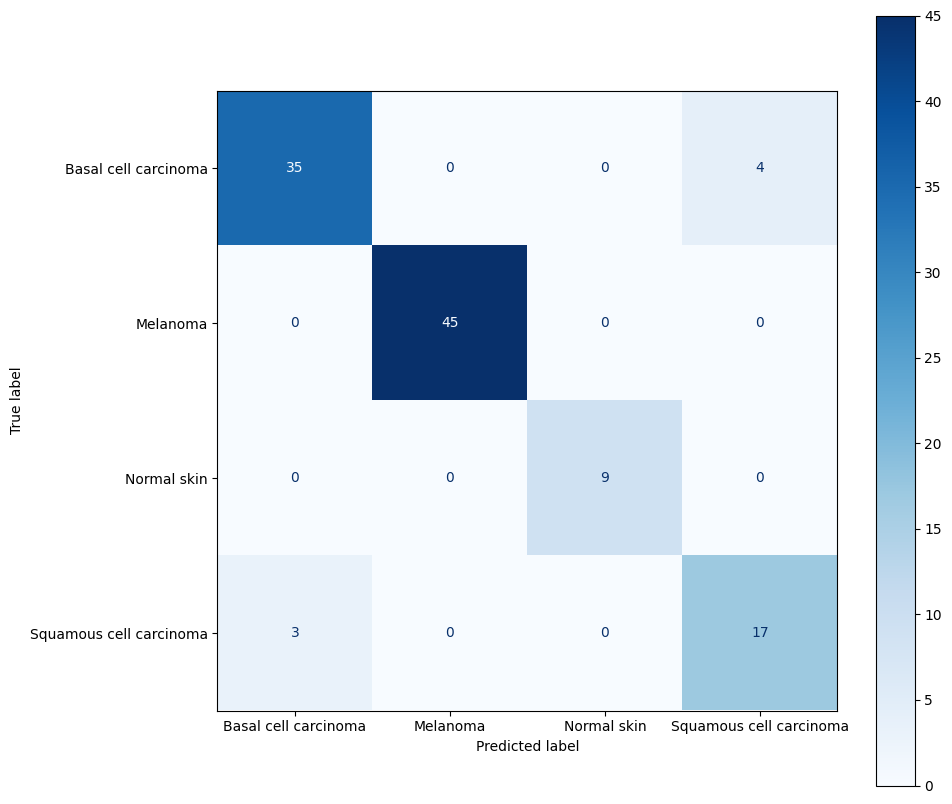

,class,specificity,sensitivity
0,0,0.959459,0.897436
1,1,1.000000,1.000000
2,2,1.000000,1.000000
3,3,0.956989,0.850000


In [18]:
import sklearn as scikit_learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

test_true=test_generator.classes[test_generator.index_array]
test_pred_raw = model_0.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()


res = []
for l in range(CLASS_SIZE):
    pres,recall,_,_ = precision_recall_fscore_support(np.array(test_true)==l,np.array(test_pred)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])


In [19]:
from sklearn.metrics import classification_report


report = classification_report(test_true, test_pred, target_names=class_names)
print(report)


                         precision    recall  f1-score   support

   Basal cell carcinoma       0.92      0.90      0.91        39
               Melanoma       1.00      1.00      1.00        45
            Normal skin       1.00      1.00      1.00         9
Squamous cell carcinoma       0.81      0.85      0.83        20

               accuracy                           0.94       113
              macro avg       0.93      0.94      0.93       113
           weighted avg       0.94      0.94      0.94       113



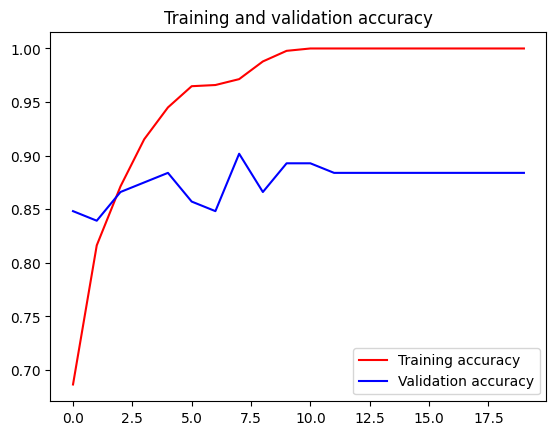

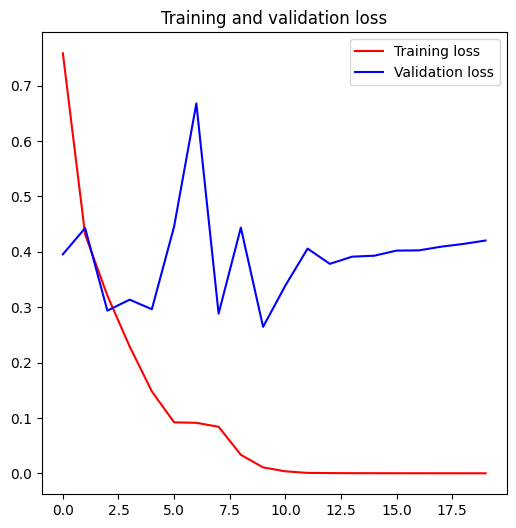

<Figure size 600x600 with 0 Axes>

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.show()


#5. Save & Load h5 Model


หลังจากการ Train Model จะนำไปสู่ขั้นตอนเก็บโมเดลหรือการ export มาจาก colab เพื่่อนำไปใช้งานต่อ ได้ดังนี้

In [21]:
# Save the trained model to a .h5 file
model_0.save('/content/gdrive/MyDrive/dataset/model/trainedmodel.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/dataset/model/trainedmodel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()
open("/content/gdrive/MyDrive/dataset/model/tflitemodel.tflite", "wb").write(tflite_model)


6594992

#6.Deploy and Test with real  image

In [23]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  file_name=fn

Saving Ballarat-Skin-Cancer-Centre-squamous-cell-carcinoma-1.jpg to Ballarat-Skin-Cancer-Centre-squamous-cell-carcinoma-1 (2).jpg
User uploaded file "Ballarat-Skin-Cancer-Centre-squamous-cell-carcinoma-1 (2).jpg" with length 138612 bytes


1/1 [==============================] - 3s 3s/step
Image name: Ballarat-Skin-Cancer-Centre-squamous-cell-carcinoma-1 (2).jpg
Predicted class: Basal cell carcinoma (94.35%)
Prediction:  ['94.35%', '5.10%', '0.55%', '0.00%']


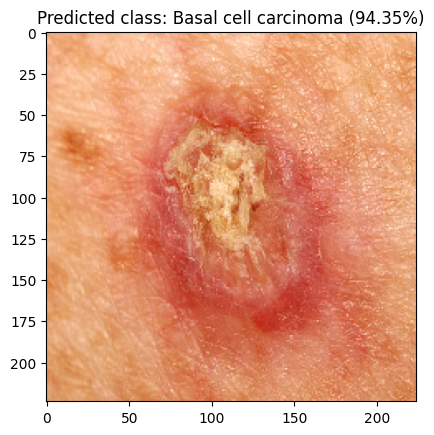

In [24]:
img = image.load_img(file_name, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

    # Make prediction
prediction = model.predict(img_array)
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()} # reverse the class_indices dictionary
predicted_class = np.argmax(prediction, axis=1)
predicted_class_name = class_names[predicted_class[0]]
predicted_prob = np.max(prediction, axis=1)

    # Print the result
print("Image name:", file_name)
print("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
prediction_list = prediction.tolist() # Convert the NumPy array to a Python list
prediction_formatted = ["{:.2%}".format(p) for p in prediction_list[0]]
print("Prediction: ", prediction_formatted)
plt.imshow(img)
plt.title("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
plt.show()
print("\n")